In [1]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add

In [2]:
# # Load samples (updated 0214)
# df0 = {}
# df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_YZ_ntuple.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_FJ_ntuple_id0-499.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_woFJ_ntuple_id0-999.root"])[1100000:] # exclude training samples
# df0["wjets"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/WJetsToLNu_HT150_ntuple_id0-999.root")[1100000:] # exclude training samples
# df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_ntuple_id0-99.root")
# df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_ntuple_id0-99.root")
# # df0["wjets_nocut"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WJetsToLNu_ntuple_id0-99.root")

# df0["tbh_m60"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH60_FJ_ntuple_id0-24.root")
# df0["tbh_m70"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH70_FJ_ntuple_id0-24.root")
# df0["tbh_m80"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH80_FJ_ntuple_id0-24.root")
# df0["tbh_m90"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH90_FJ_ntuple_id0-24.root")

# df0["tbh_m100"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH100_FJ_ntuple_id0-24.root")
# df0["tbh_m110"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH110_FJ_ntuple_id0-24.root")
# df0["tbh_m120"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH120_FJ_ntuple_id0-24.root")
# df0["tbh_m130"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH130_FJ_ntuple_id0-24.root")
# df0["tbh_m140"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH140_FJ_ntuple_id0-24.root")
# df0["tbh_m150"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH150_FJ_ntuple_id0-24.root")
# df0["tbh_m160"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH160_FJ_ntuple_id0-24.root")


In [2]:
# Load samples (updated 0316)
df0 = {}
df0["ttbarsl"] = uproot.lazy(["/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_YZ_ntuple.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_FJ_ntuple_id0-499.root", "/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_woFJ_ntuple_id0-999.root"])[1100000:] # exclude training samples
df0["wjets"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/WJetsToLNu_HT150_ntuple_id0-999.root")[1100000:] # exclude training samples
df0["wwsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WWSL_ntuple_id0-99.root")
df0["twsl"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/TWSL_ntuple_id0-99.root")
# df0["wjets_nocut"] = uproot.lazy("/data/bond/licq/delphes/sm_1l/merged_ntuple/WJetsToLNu_ntuple_id0-99.root")

df0["tbh_m60"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH60_FJ_ntuple_id0-199.root")
df0["tbh_m70"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH70_FJ_ntuple_id0-199.root")
df0["tbh_m80"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH80_FJ_ntuple_id0-199.root")
df0["tbh_m90"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH90_FJ_ntuple_id0-199.root")

df0["tbh_m100"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH100_FJ_ntuple_id0-199.root")
df0["tbh_m110"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH110_FJ_ntuple_id0-199.root")
df0["tbh_m120"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH120_FJ_ntuple_id0-199.root")
df0["tbh_m130"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH130_FJ_ntuple_id0-199.root")
df0["tbh_m140"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH140_FJ_ntuple_id0-199.root")
df0["tbh_m150"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH150_FJ_ntuple_id0-199.root")
df0["tbh_m160"] = uproot.lazy("/data/bond/licq/delphes/sm_1l_fj/merged_ntuple/TTbarSL_TToBHpmToBBC_MH160_FJ_ntuple_id0-199.root")


In [3]:
# total lumi for Run2 + Run3
lumi_tot = 450 # fb-1

# compute weights from un-selected events
weights = {
    "ttbarsl": (lumi_tot / 100.) * 2250000 / len(df0["ttbarsl"]), # number of events passing 1 fj selection
    "wjets": (lumi_tot / 100.) * 6290000 / len(df0["wjets"]), # number of events passing 1 fj selection
    "wwsl": (lumi_tot / 100.) * 1615000 / len(df0["wwsl"]),
    "twsl": (lumi_tot / 100.) * 1108000 / len(df0["twsl"]),

    "tbh_m60": (lumi_tot / 100.) * 33139 / len(df0["tbh_m60"]),
    "tbh_m70": (lumi_tot / 100.) * 32560 / len(df0["tbh_m70"]),
    "tbh_m80": (lumi_tot / 100.) * 32375 / len(df0["tbh_m80"]),
    "tbh_m90": (lumi_tot / 100.) * 31833 / len(df0["tbh_m90"]),
    "tbh_m100": (lumi_tot / 100.) * 31767 / len(df0["tbh_m100"]),
    "tbh_m110": (lumi_tot / 100.) * 32036 / len(df0["tbh_m110"]),
    "tbh_m120": (lumi_tot / 100.) * 32151 / len(df0["tbh_m120"]),
    "tbh_m130": (lumi_tot / 100.) * 32359 / len(df0["tbh_m130"]),
    "tbh_m140": (lumi_tot / 100.) * 32811 / len(df0["tbh_m140"]),
    "tbh_m150": (lumi_tot / 100.) * 33169 / len(df0["tbh_m150"]),
    "tbh_m160": (lumi_tot / 100.) * 33703 / len(df0["tbh_m160"]),
}
print({sam: len(df0[sam]) for sam in df0})
print(weights)

# {'ttbarsl': 2570425, 'wjets': 4157131, 'wwsl': 2198372, 'twsl': 1803005, 'wjets_nocut': 2758550}
# {'ttbarsl': 0.8753416263847418, 'wjets': 1.513062734852474, 'wwsl': 0.7346345386495098, 'twsl': 0.6145296324746742, 'wjets_nocut': 653.2417393195701}

{'ttbarsl': 5216209, 'wjets': 4841933, 'wwsl': 2198372, 'twsl': 1803005, 'tbh_m60': 492519, 'tbh_m70': 485629, 'tbh_m80': 480435, 'tbh_m90': 475480, 'tbh_m100': 473763, 'tbh_m110': 474951, 'tbh_m120': 478268, 'tbh_m130': 483679, 'tbh_m140': 489676, 'tbh_m150': 497989, 'tbh_m160': 498822}
{'ttbarsl': 1.9410648614731503, 'wjets': 5.8458057969823205, 'wwsl': 3.305855423922794, 'twsl': 2.765383346136034, 'tbh_m60': 0.30278121250144663, 'tbh_m70': 0.3017118005720416, 'tbh_m80': 0.30324081301320677, 'tbh_m90': 0.30127134684949947, 'tbh_m100': 0.30173631119357147, 'tbh_m110': 0.3035302589109192, 'tbh_m120': 0.3025071717112581, 'tbh_m130': 0.3010581397993297, 'tbh_m140': 0.30152488584288384, 'tbh_m150': 0.2997264999829313, 'tbh_m160': 0.30404332607623563}


In [4]:
def _get_p4_from_index(_df, obj_str, idx):
    return _p4_from_ptetaphie(
        getattr(_df, obj_str + '_pt')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_eta')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_phi')[ak.singletons(idx)][:, 0],
        getattr(_df, obj_str + '_energy')[ak.singletons(idx)][:, 0],
    )
btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}
ftag_wp = {"T_b1": 0.8493, "T_b2": 0.5881, "T_c1": 0.7574, "T_c2": 0.2963}

# new variables and selections
df = {}
for sam in df0:
    # fajet selections
    df[sam] = df0[sam][ak.num(df0[sam].fj_pt) > 0]
    d = df[sam]

    # fatjet sophon discr
    df[sam]["fj_sophon_discr"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr2"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)
    df[sam]["fj_sophon_discr3"] = d.fj_sophon_probXbc / (d.fj_sophon_probXbc + d.fj_sophon_probXbq + d.fj_sophon_probXcs + d.fj_sophon_probXqq + d.fj_sophon_probXbqq + d.fj_sophon_probQCD)

    # fatjet candidate
    df[sam]["fjcand_p4"] = _get_p4_from_index(d, "fj", np.zeros(len(d), dtype=int))
    df[sam]["fjcand_sdmass"] = d.fj_sdmass[:,0]

    # fatjet candidate-m (with largest Sophon discr)
    df[sam]["fjcandm_idx"] = ak.argmax(d.fj_sophon_discr, axis=1)
    df[sam]["fjcandm_p4"] = _get_p4_from_index(d, "fj", d.fjcandm_idx)
    df[sam]["fjcandm_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm_idx)][:, 0]
    df[sam]["fjcandm2_idx"] = ak.argmax(d.fj_sophon_discr2, axis=1)
    df[sam]["fjcandm2_p4"] = _get_p4_from_index(d, "fj", d.fjcandm2_idx)
    df[sam]["fjcandm2_sdmass"] = d.fj_sdmass[ak.singletons(d.fjcandm2_idx)][:, 0]

    # obj p4
    df[sam]["jet_p4"] = _p4_from_ptetaphie(d.jet_pt, d.jet_eta, d.jet_phi, d.jet_energy)
    df[sam]["lep_p4"] = _p4_from_ptetaphie(d.lep_pt, d.lep_eta, d.lep_phi, d.lep_energy)
    zeros = ak.zeros_like(d.lep_pt)
    df[sam]["met_p4"] = _p4_from_ptetaphim(d.met_pt, zeros, d.met_phi, zeros) # note: this is ptetaphim!

    # ### Temporarily commented out ###
    # ## select exclusive LP b jets (for Yuzhe's workflow)
    # df[sam]["extbtagMPjet_p4"] = d.jet_p4[(d.jet_sophonAK4_probB > btag_wp["M"]) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)]

    # extbtagMPjet_12_pair = ak.combinations(d.extbtagMPjet_p4[:, :2], 2)
    # df[sam]["dr_extbtagMPjet_12"] = ak.fill_none(ak.firsts(extbtagMPjet_12_pair['0'].deltaR(extbtagMPjet_12_pair['1'])), -1)
    # df[sam]["dr_extbtagMPjet_12_fjcand_min"] = ak.fill_none(ak.firsts(
    #     np.minimum(extbtagMPjet_12_pair['0'].deltaR(d.fjcand_p4), extbtagMPjet_12_pair['1'].deltaR(d.fjcand_p4))
    # ), 99.)

    # # select MP b jets (for ParticleNetSFs workflow)
    # df[sam]["btagMPjet_p4"] = d.jet_p4[d.jet_sophonAK4_probB > btag_wp["M"]]
    # df[sam]["dr_btagMPjet_lep_min"] = ak.fill_none(ak.min(d.btagMPjet_p4.deltaR(d.lep_p4), axis=1), 99.)
    # df[sam]["dr_lep_fjcand"] = d.lep_p4.deltaR(d.fjcand_p4)
    # df[sam]["lepmet_pt"] = (d.lep_p4 + d.met_p4).pt

    # genpart p4 and matchings
    if 'wjets' not in sam:
        df[sam]["whad_idx"] = ak.fill_none(ak.argmax(((np.abs(d.genpart_pid[:, :-1]) == 24) | (np.abs(d.genpart_pid[:, :-1]) == 37)) & (np.abs(d.genpart_pid[:, 1:]) <= 5), axis=1), 0)

        df[sam]["whad_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx)
        df[sam]["whad_dau1_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 1)
        df[sam]["whad_dau2_p4"] = _get_p4_from_index(d, "genpart", d.whad_idx + 2)
        df[sam]["whad_dau1_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 1)][:, 0]
        df[sam]["whad_dau2_pid"] = d.genpart_pid[ak.singletons(d.whad_idx + 2)][:, 0]

        # if whad follows a b quark, it is from a thad
        df[sam]["thad_b_idx"] = ak.where(
            np.abs(d.genpart_pid[ak.singletons(np.maximum(d.whad_idx - 1, 0))][:, 0]) == 5,
            d.whad_idx - 1,
            -1,
        )
        df[sam]["thad_b_p4"] = _get_p4_from_index(d, "genpart", d.thad_b_idx)

        # check matching criteria
        b_matched = (d.thad_b_idx >= 0) & (d.fjcand_p4.deltaR(d.thad_b_p4) < 0.8)
        wdau1_matched = d.fjcand_p4.deltaR(d.whad_dau1_p4) < 0.8
        wdau2_matched = d.fjcand_p4.deltaR(d.whad_dau2_p4) < 0.8
        df[sam]["is_t_matched"] = b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_w_matched"] = ~b_matched & wdau1_matched & wdau2_matched
        df[sam]["is_tbc_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) == 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) == 4)) & ~wdau1_matched)
        df[sam]["is_tbq_matched"] = (b_matched & (wdau1_matched & (np.abs(d.whad_dau1_pid) != 4)) & ~wdau2_matched) | \
                                     (b_matched & (wdau2_matched & (np.abs(d.whad_dau2_pid) != 4)) & ~wdau1_matched)
        df[sam]["is_non_matched"] = ~d.is_t_matched & ~d.is_w_matched & ~d.is_tbc_matched & ~d.is_tbq_matched

    # infer event DNN scores (tbh training)
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/newsignal/pred_{sam}.root')
    for b in ["score_is_w_matched", "score_is_tbQ_matched", "score_is_non_matched", "score_is_wjets"]:
        df[sam][b] = _df[b]
        
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/wcb_boostedtbh_evtobj_ftagcat_wtmatch.noweights.nobj8.pt25.fjpt300/pred_{sam}.root')
    for b in ["score_is_w_matched"]:
        df[sam][b + "_pt300"] = _df[b]
        
    _df = uproot.lazy(f'/home/pku/zhaoyz/pheno/notebooks_hbc/dnn/wcb_boostedtbh_evtobj_ftagcat_wtmatch.noweights.nobj8.pt25.fjpt400.nbatch200/pred_{sam}.root')
    for b in ["score_is_w_matched"]:
        df[sam][b + "_pt400"] = _df[b]

    # custom flavour tagging
    df[sam]["jet_ftag_B1"] = d.jet_sophonAK4_probB > ftag_wp["T_b1"]
    df[sam]["jet_ftag_B2"] = (d.jet_sophonAK4_probB > ftag_wp["T_b2"]) & ~d.jet_ftag_B1
    df[sam]["jet_ftag_C1"] = (d.jet_sophonAK4_probC > ftag_wp["T_c1"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2
    df[sam]["jet_ftag_C2"] = (d.jet_sophonAK4_probC > ftag_wp["T_c2"]) & ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1
    df[sam]["jet_ftag_N"] = ~d.jet_ftag_B1 & ~d.jet_ftag_B2 & ~d.jet_ftag_C1 & ~d.jet_ftag_C2


print({sam: len(df[sam]) for sam in df})

{'ttbarsl': 4814736, 'wjets': 4552037, 'wwsl': 134177, 'twsl': 243680, 'tbh_m60': 454657, 'tbh_m70': 447771, 'tbh_m80': 442933, 'tbh_m90': 438655, 'tbh_m100': 436680, 'tbh_m110': 437708, 'tbh_m120': 440541, 'tbh_m130': 446073, 'tbh_m140': 452354, 'tbh_m150': 459587, 'tbh_m160': 460678}


In [5]:
# Categories
from types import SimpleNamespace
config = SimpleNamespace(
    categories = { # category name: (sample list, selection, label, color)

        # the official version
        "bkg_wjets": (["wjets"], "d.lep_pt > 0", r"W+jets", "lightcyan"),
        "bkg_t_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_t_matched", r"$t\overline{t}+tW+WW$: top($bqq'$)", "blue"),
        "bkg_tbc_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbc_matched", r"$t\overline{t}+tW+WW$: top($bc$)", "orange"),
        "bkg_tbq_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_tbq_matched", r"$t\overline{t}+tW+WW$: top($bq$)", "wheat"),
        "bkg_non_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_non_matched", r"$t\overline{t}+tW+WW$: non", "darkcyan"),
        "bkg_w_matched": (["ttbarsl", "wwsl", "twsl"], "~d.is_wcb & d.is_w_matched", r"$t\overline{t}+tW+WW$: $W(qq')$", "red"),
        # signals
        "sig_tbh_m60":  (["tbh_m60"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=60$ GeV)", "red"),
        "sig_tbh_m70":  (["tbh_m70"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=70$ GeV)", "orange"),
        "sig_tbh_m80":  (["tbh_m80"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=80$ GeV)", "yellow"),
        "sig_tbh_m90":  (["tbh_m90"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=90$ GeV)", "green"),
        "sig_tbh_m100": (["tbh_m100"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=100$ GeV)", "cyan"),
        "sig_tbh_m110": (["tbh_m110"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=110$ GeV)", "blue"),
        "sig_tbh_m120": (["tbh_m120"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=120$ GeV)", "purple"),
        "sig_tbh_m130": (["tbh_m130"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=130$ GeV)", "magenta"),
        "sig_tbh_m140": (["tbh_m140"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=140$ GeV)", "brown"),
        "sig_tbh_m150": (["tbh_m150"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=150$ GeV)", "gray"),
        "sig_tbh_m160": (["tbh_m160"], "d.lep_pt > 0", r"Signal $H^{\pm}\rightarrow bc$ ($m_{H^{\pm}}=160$ GeV)", "black"),

    },

    variables = {
        "n_fj": ("ak.num(d.fj_pt)", bh.axis.Regular(5, 0, 5)),
        "fjcand_pt": ("d.fjcand_p4.pt", bh.axis.Regular(50, 0, 500)),
        "fjcand_eta": ("d.fjcand_p4.eta", bh.axis.Regular(50, -5, 5)),
        "fjcand_mass": ("d.fjcand_p4.mass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass": ("d.fjcand_sdmass", bh.axis.Regular(50, 0, 250)),
        "fjcand_sdmass_bw10": ("d.fjcand_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcandm_sdmass_bw10": ("d.fjcandm_sdmass", bh.axis.Regular(25, 0, 250)),
        "fjcand_sophon_discr": ("d.fj_sophon_discr[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr2": ("d.fj_sophon_discr2[:,0]", bh.axis.Regular(100, 0., 1)),
        "fjcand_sophon_discr_custom": ("d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0])", bh.axis.Regular(100, 0.5, 1)),
        "lep_pt": ("d.lep_pt", bh.axis.Regular(50, 0, 500)),
        "lep_eta": ("d.lep_eta", bh.axis.Regular(50, -5, 5)),
        "met_pt": ("d.met_pt", bh.axis.Regular(50, 0, 500)),
        "wlep_pt": ("(d.met_p4 + d.lep_p4).pt", bh.axis.Regular(50, 0, 500)),
        "n_extbtagMPjet": ("ak.num(d.extbtagMPjet_p4)", bh.axis.Regular(6, 0, 6)),
        # "n_extbtagMPjet": ("ak.num(d.jet_p4[(d.jet_sophonAK4_probB > 0.297) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(6, 0, 6)),
        "n_extjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8)])", bh.axis.Regular(10, 0, 10)),
        "n_cleanjet": ("ak.num(d.jet_p4[(d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_p4.deltaR(d.lep_p4) > 0.4)])", bh.axis.Regular(10, 0, 10)),
        "evt_dnn_score": ("d.score_is_w_matched", bh.axis.Regular(20, 0, 1)),
        "evt_dnn_score_high": ("d.score_is_w_matched", bh.axis.Regular(25, 0.8, 1)),
        "evt_dnn_score_tonly": ("d.score_is_w_matched / (1 - d.score_is_wjets)", bh.axis.Regular(50, 0, 1)),
        "dr_extbtagMPjet_12_fjcand_min": ("d.dr_extbtagMPjet_12_fjcand_min", bh.axis.Regular(30, 0, 6)),

        # for template making
        "sophon_discr2_dnn_hist2d": (("d.fj_sophon_discr2[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
        "sophon_discr3_dnn_hist2d": (("d.fj_sophon_discr3[:,0]", "d.score_is_w_matched"), (bh.axis.Regular(100, 0.9, 1), bh.axis.Regular(100, 0, 1))),
    },

    signal_mul_factor = 1,

    categories_merged = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
        # "sig": ["sig_t_matched", "sig_w_matched", "sig_tbc_matched", "sig_tbq_matched", "sig_non_matched"],
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    sig_list = {
        "sig_m60": [ "sig_tbh_m60"],
        "sig_m70": [ "sig_tbh_m70"],
        "sig_m80": [ "sig_tbh_m80"],
        "sig_m90": [ "sig_tbh_m90"],
        "sig_m100":[ "sig_tbh_m100"],
        "sig_m110":[ "sig_tbh_m110"],
        "sig_m120":[ "sig_tbh_m120"],
        "sig_m130":[ "sig_tbh_m130"],
        "sig_m140":[ "sig_tbh_m140"],
        "sig_m150":[ "sig_tbh_m150"],
        "sig_m160":[ "sig_tbh_m160"],
    },
    bkg_list = {
        "bkg_wjets": ["bkg_wjets"],
        "bkg_allwhad_tbc": ["bkg_tbc_matched"],
        "bkg_allwhad_others": ["bkg_t_matched", "bkg_w_matched", "bkg_tbq_matched", "bkg_non_matched"],
    },
)
# btag_wp = {"L": 0.0557, "M": 0.297, "T": 0.725}


In [6]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [7]:
# dfc.keys()
# dfc[('bkg_wjets', 'wjets')]

### Plotting

Selection: (d.fjcand_p4.pt > 400) & (d.fj_sophon_discr2[:,0] > 0.95) & (d.fjcand_sdmass > 0)
Variable: d.fjcand_sdmass
Processing bkg_wjets wjets
Processing bkg_t_matched ttbarsl
Processing bkg_t_matched wwsl
Processing bkg_t_matched twsl


Processing bkg_tbc_matched ttbarsl
Processing bkg_tbc_matched wwsl
Processing bkg_tbc_matched twsl
Processing bkg_tbq_matched ttbarsl
Processing bkg_tbq_matched wwsl
Processing bkg_tbq_matched twsl
Processing bkg_non_matched ttbarsl
Processing bkg_non_matched wwsl
Processing bkg_non_matched twsl
Processing bkg_w_matched ttbarsl
Processing bkg_w_matched wwsl
Processing bkg_w_matched twsl
Processing sig_tbh_m60 tbh_m60
Processing sig_tbh_m70 tbh_m70
Processing sig_tbh_m80 tbh_m80
Processing sig_tbh_m90 tbh_m90
Processing sig_tbh_m100 tbh_m100
Processing sig_tbh_m110 tbh_m110
Processing sig_tbh_m120 tbh_m120
Processing sig_tbh_m130 tbh_m130
Processing sig_tbh_m140 tbh_m140
Processing sig_tbh_m150 tbh_m150
Processing sig_tbh_m160 tbh_m160
bkg_wjets 145.5
bkg_t_matched 477.7
bkg_tbc_matched 1346.0
bkg_tbq_matched 35.0
bkg_non_matched 100.3
bkg_w_matched 11.9
sig_tbh_m60 102.2
sig_tbh_m70 95.2
sig_tbh_m80 103.5
sig_tbh_m90 100.2
sig_tbh_m100 100.4
sig_tbh_m110 95.3
sig_tbh_m120 101.5
sig_tbh

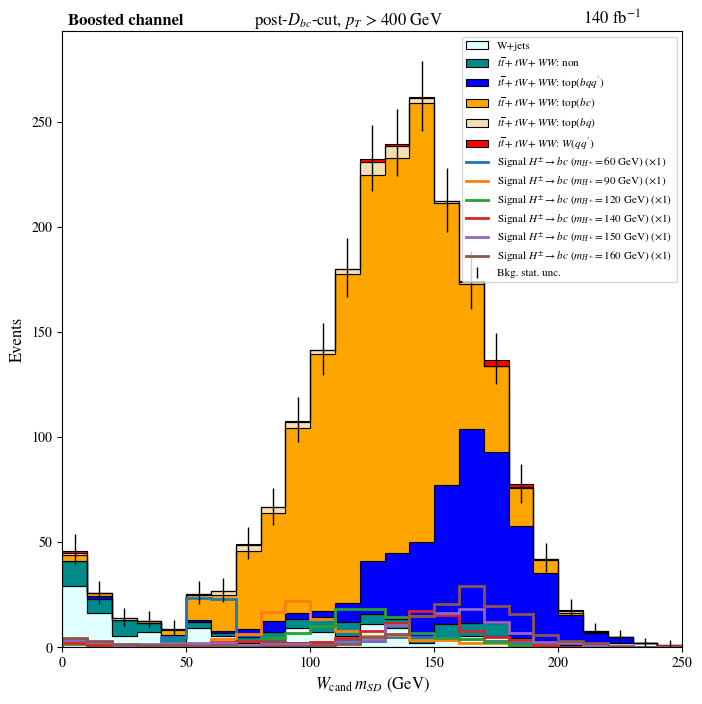

In [26]:
pt_range_index = 3
basesel_expr_name_var = {
    0 : ("(d.fjcand_p4.pt > 200) & (d.fjcand_p4.pt <= 250)", r"200 GeV < $p_{T}$ < 250 GeV"),
    1 : ("(d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt <= 300)", r"250 GeV < $p_{T}$ < 300 GeV"),
    2 : ("(d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt <= 400)", r"300 GeV < $p_{T}$ < 400 GeV"),
    3 : ("(d.fjcand_p4.pt > 400)", r"$p_{T}$ > 400 GeV")
}

basesel_expr = basesel_expr_name_var[pt_range_index][0]
# basesel_expr = "(d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt < 300)"
# basesel_expr = "(d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt < 400)"
# basesel_expr = "(d.fjcand_p4.pt > 400)"
# basesel_expr = "(ak.num(d.extbtagMPjet_p4) == 2) & (d.dr_extbtagMPjet_12 > 1.) & (d.dr_extbtagMPjet_12_fjcand_min < 2.)"

# try ParticleNetSFs cut:
# basesel_expr = "(d.lep_pt > 50.) & (d.met_pt > 50.) & (d.dr_btagMPjet_lep_min < 2.) & (d.dr_lep_fjcand > 2.) & (d.lepmet_pt > 100.)"

# tagger cut
# basesel_expr += " & (d.fj_sophon_discr[:,0] > 0.95)"
# basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.5)"
# basesel_expr += " & (d.fj_sophon_probXbc[:,0] / (d.fj_sophon_probXbc[:,0] + d.fj_sophon_probXbq[:,0] + d.fj_sophon_probXcs[:,0] + d.fj_sophon_probXqq[:,0] + d.fj_sophon_probXbqq[:,0] + 10*d.fj_sophon_probQCD[:,0]) > 0.93)"
basesel_expr += " & (d.fj_sophon_discr2[:,0] > 0.3)"

# DNN cut
# basesel_expr += " & (d.score_is_w_matched > 0.5)"
# basesel_expr += " & (d.score_is_w_matched_pt300 > 0.7)"
# basesel_expr += " & (d.score_is_w_matched_pt400 > 0.1)"

# mass window cut
# basesel_expr += " & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"

basesel_expr += " & (d.fjcand_sdmass > 0)" 


# basesel_expr = " (d.fjcand_sdmass > 0)"

# varname = "wlep_pt"; varlabel=""; do_plotting = True
varname = "fjcand_sdmass_bw10"; varlabel=r"$W_{\mathrm{cand}}\;m_{SD}$ (GeV)"; do_plotting = True
# varname = "evt_dnn_score"; varlabel="Boosted-channel event classifier score"; do_plotting = True
# varname = "evt_dnn_score_high"; varlabel="Boosted-channel event classifier score"; do_plotting = True
# varname = "fjcand_sdmass_bw10"; varlabel="W cand mass"; do_plotting = True
# varname = "fjcand_pt"; varlabel="W cand pT"; do_plotting = True

# aux weights
actural_lumi = 140. # fb-1

categories_to_draw = [
    # official version
    "bkg_wjets",
    "bkg_non_matched", "bkg_t_matched", "bkg_tbc_matched", "bkg_tbq_matched", "bkg_w_matched",
    # signals
    "sig_tbh_m60", "sig_tbh_m90", "sig_tbh_m120", "sig_tbh_m140", "sig_tbh_m150", "sig_tbh_m160",
    ]

varexpr, varaxis = config.variables[varname]
print("Selection:", basesel_expr)
print("Variable:", varexpr)

from scipy.stats import chi2
def garwood_interval(N, alpha=0.317):
    lower_bound = 0 if N == 0 else chi2.ppf(alpha/2, 2*N) / 2
    upper_bound = chi2.ppf(1 - alpha/2, 2*(N+1)) / 2
    return lower_bound, upper_bound

def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
    def _fill_hist(input):
        vals, weights = input
        hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
        hist.fill(vals, weight=weights)
        return hist

    if nthreads == 1:
        return _fill_hist((var_array, weight_array))
    else:
        with ThreadPoolExecutor(nthreads) as pool:
            hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
        hist = reduce(add, hist)
        return hist

def _plotter(input):
    cname, sam = input
    print('Processing', cname, sam)
    # base selection
    d = dfc[(cname, sam)]
    d = d[eval(basesel_expr)]
    # fill histogram
    var_array = eval(varexpr)
    weight_array = np.ones(len(d))
    hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
    # yields ... tbd
    # yld = len(d[(d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)])
    yld = len(d)
    return hist, yld

# generate inputs to send into concurrent plotter
zipped_input = []
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        zipped_input.append((cname, sam))

# plotting
if do_plotting:
    with ThreadPoolExecutor(2) as pool:
        results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

# retreive and group results for each category
contents, variances, contents_mass_win = {}, {}, {}
for cname, (samlist, sel, label, color) in config.categories.items():
    hists = []
    contents_mass_win[cname] = 0
    for sam in samlist:
        hists.append(results[(cname, sam)][0] * weights[sam] * (actural_lumi / 450.))
        contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam] * (actural_lumi / 450.)
    hist = sum(hists)
    contents[cname], variances[cname] = hist.view().value, hist.view().variance
    print(cname, round(contents_mass_win[cname], 1))
    
print(
    '**Significance**',
    sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("sig")]) / np.sqrt(sum([contents_mass_win[cname] for cname in config.categories if cname.startswith("bkg")])),
)

# plotting: stacked histogram
fig, ax = plt.subplots(figsize=(8, 8))
hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
hep.histplot(
    [contents[cname] for cname in categories_to_draw if cname.startswith("bkg")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] for cname in categories_to_draw if cname.startswith("bkg")],
    color=[config.categories[cname][3] for cname in categories_to_draw if cname.startswith("bkg")],
    histtype='fill', edgecolor='k', linewidth=0.8, stack=True,
)
# plotting: signals
hep.histplot(
    [contents[cname] * config.signal_mul_factor for cname in categories_to_draw if cname.startswith("sig")],
    bins=hist.axes[0].edges,
    label=[config.categories[cname][2] + f' (×{config.signal_mul_factor})' for cname in categories_to_draw if cname.startswith("sig")],
    linewidth=2,
)
# SM errorbar
## histogram tmpl uncertainty
# ax.errorbar(
#     (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
#     sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")]),
#     yerr=np.sqrt(sum([variances[cname] for cname in categories_to_draw if not cname.startswith("sig")])),
#     label='Bkg. unc.', color='black', linewidth=1, linestyle='none',
# )
## mimic the statistical uncertainty
bkg_bin_counts = sum([contents[cname] for cname in categories_to_draw if not cname.startswith("sig")])
bkg_bin_err_lo, bkg_bin_err_hi = abs(bkg_bin_counts - np.array([garwood_interval(N) for N in bkg_bin_counts]).T)
ax.errorbar(
    (hist.axes[0].edges[:-1] + hist.axes[0].edges[1:])/2.,
    bkg_bin_counts,
    yerr=[bkg_bin_err_lo, bkg_bin_err_hi],
    label='Bkg. stat. unc.', color='black', linewidth=1, linestyle='none',
)

ax.set_xlim(varaxis.edges[0], varaxis.edges[-1])
ax.set_xlabel(varlabel, fontsize=12)
ax.set_ylabel("Events", fontsize=12)
# ax.set_yscale("log")
ax.legend(prop={'size': 8}, loc='upper right', ncol=1, columnspacing=0.6, labelspacing=0.4)#, handletextpad=0.2, borderpad=0.5)
ax.text(0.01, 1.01, r"Boosted channel", fontsize=12, fontweight='bold', transform=ax.transAxes)
ax.text(0.31, 1.01, r"post-$D_{bc}$-cut, " + basesel_expr_name_var[pt_range_index][1], fontsize=12, transform=ax.transAxes)
ax.text(0.84, 1.01, r"%d $\mathrm{fb}^{-1}$" % actural_lumi, fontsize=12, transform=ax.transAxes)
plt.savefig(f"./{varname}.pdf", bbox_inches='tight')
plt.show()

### Make new templates (below is added by Yuzhe)

In [24]:
# Assign the SF value from the SF tables depending on truth label, ftag region, and pT
ftag_sf = {
    "bjet": {
        "pt_edges": [20, 30, 40, 60, 100, 175, 250],
        "B1": [0.07, 0.04, 0.03, 0.01, 0.01, 0.02, 0.03],
        "B2": [0.07, 0.04, 0.03, 0.02, 0.03, 0.04, 0.08],
        "C1": [0.06, 0.03, 0.02, 0.02, 0.03, 0.06, 0.14],
        "C2": [0.05, 0.03, 0.01, 0.01, 0.02, 0.04, 0.10],
        "N":  [0.20, 0.12, 0.08, 0.05, 0.07, 0.08, 0.13],
    },
    "cjet": {
        "pt_edges": [20, 40, 65, 140],
        "B1": [0.10, 0.08, 0.08, 0.08],
        "B2": [0.10, 0.05, 0.05, 0.06],
        "C1": [0.10, 0.04, 0.04, 0.04],
        "C2": [0.07, 0.07, 0.06, 0.06],
        "N":  [0.07, 0.04, 0.04, 0.04],
    },
    "ljet": {
        "pt_edges": [20, 50, 100, 150],
        "B1": [0.23, 0.22, 0.24, 0.20],
        "B2": [0.22, 0.22, 0.25, 0.20],
        "C1": [0.12, 0.12, 0.13, 0.12], 
        "C2": [0.13, 0.13, 0.13, 0.12],
        "N":  [0.0035, 0.0025, 0.0025, 0.0022],
    },
}
for sam in df:
    d = df[sam]

    # flatten the pT array
    jet_pt_flat = ak.flatten(d.jet_pt)
    counts = ak.num(d.jet_pt)

    # initiate SFs
    sf = np.zeros(len(jet_pt_flat))

    for flv in ["bjet", "cjet", "ljet"]:
        if flv == "bjet":
            truth_flag = (d.jet_flavor == 5)
        elif flv == "cjet":
            truth_flag = (d.jet_flavor == 4)
        else:
            truth_flag = (d.jet_flavor != 5) & (d.jet_flavor != 4)

        # for each truth flavour, assign the corresponding SF from the 5 regions and the corresponding SF table
        for ch in ["B1", "B2", "C1", "C2", "N"]:
            _idx = np.searchsorted(ftag_sf[flv]["pt_edges"], np.maximum(ak.to_numpy(jet_pt_flat), 20+1e-8)) - 1
            _sf = np.array(ftag_sf[flv][ch])[_idx]
            flag_flat = ak.flatten(truth_flag * getattr(d, f"jet_ftag_{ch}"))
            sf = sf + _sf * flag_flat

    df[sam]['jet_ftag_SF'] = ak.unflatten(sf, counts)

In [25]:
# cached df
dfc = {}
for cname, (samlist, sel, label, color) in config.categories.items():
    for sam in samlist:
        d = df[sam]
        dfc[(cname, sam)] = df[sam][eval(sel)]

In [48]:
# dft = dfc[('bkg_wjets', 'wjets')]
# dft[(dft.fj_sophon_discr2[:,0] > 0.95) & (dft.score_is_w_matched > 0.3) & (dft.fjcand_p4.pt > 100)]


<Array [{jet_px: [-62.1, 150, ... 0.01, 0.07]}] type='6 * {"jet_px": var * float...'>

In [22]:
# dfc[("sig_tbh_m60", "tbh_m60")]

<Array [{jet_px: [670, -415, ... 0.0035]}] type='56986 * {"jet_px": var * float3...'>

In [149]:
def make_flv_variation_template(target_flv, target_region, target_variation, pt_bin = "pt200to250"):

    assert target_flv in ["bjet", "cjet", "ljet"]
    assert target_region in ["B1", "B2", "C1", "C2", "N"]
    assert target_variation in ["up", "down", "nominal"]
    print(f"Making template for {target_flv} in {target_region} with {target_variation} variation")

    # basesel_expr = "(d.lep_pt > 0) & (d.fjcand_sdmass > 60) & (d.fjcand_sdmass < 110)"
    basesel_expr_wo_pt = "(d.score_is_w_matched < 0.3)"
    sel_expr_pt_dict = {
        "pt200to250" : "& (d.fj_sophon_discr2[:,0] > 0.9) & (d.fjcand_p4.pt > 200) & (d.fjcand_p4.pt <= 250) ",
        "pt250to300" : "& (d.fj_sophon_discr2[:,0] > 0.67) & (d.fjcand_p4.pt > 250) & (d.fjcand_p4.pt <= 300) ",
        "pt300to400" : "& (d.fj_sophon_discr2[:,0] > 0.92) & (d.fjcand_p4.pt > 300) & (d.fjcand_p4.pt <= 400) ",
        "pt400toInf" : "& (d.fj_sophon_discr2[:,0] > 0.75) & (d.fjcand_p4.pt > 400) "
        }
    basesel_expr = basesel_expr_wo_pt + sel_expr_pt_dict[pt_bin]
    # DNN cut
    # basesel_expr += " & (d.score_is_w_matched > 0.85)"

    # varname = "sophon_discr2_dnn_hist2d"; do_plotting = True
    varname = "fjcand_sdmass_bw10"; varlabel=r"$W_{\mathrm{cand}}\;m_{SD}$ (GeV)"; do_plotting = True

    varexpr, varaxis = config.variables[varname]
    # assert isinstance(varexpr, tuple), "Only 2D hist is supported" # no need now

    print("Selection:", basesel_expr)
    print("Variable:", varexpr)

    def _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=1):
        def _fill_hist(input):
            vals, weights = input
            hist = bh.Histogram(varaxis, storage=bh.storage.Weight())
            hist.fill(vals, weight=weights)
            return hist

        if nthreads == 1:
            return _fill_hist((var_array, weight_array))
        else:
            with ThreadPoolExecutor(nthreads) as pool:
                hist = pool.map(_fill_hist, zip(np.array_split(var_array, nthreads), np.array_split(weight_array, nthreads)))
            hist = reduce(add, hist)
            return hist

    def _plotter(input):
        cname, sam = input
        print('Processing', cname, sam)
        # base selection
        d = dfc[(cname, sam)]
        d = d[eval(basesel_expr)]
        # fill histogram
        var_array = eval(varexpr)

        ##### custom weight array #####
        target_flv_map = {
            "bjet": "d.jet_flavor == 5",
            "cjet": "d.jet_flavor == 4",
            "ljet": "(d.jet_flavor != 5) & (d.jet_flavor != 4)",
        }
        target_region_map = {
            'B1': "d.jet_ftag_B1",
            'B2': "d.jet_ftag_B2",
            'C1': "d.jet_ftag_C1",
            'C2': "d.jet_ftag_C2",
            'N': "d.jet_ftag_N",
        }

        cleanjet_flag = (d.jet_p4.deltaR(d.lep_p4) > 0.4) & (d.jet_p4.deltaR(d.fjcand_p4) > 0.8) & (d.jet_pt > 25) # reminder of pt > 25 cut!
        flv_flag = eval(target_flv_map[target_flv])
        region_flag = eval(target_region_map[target_region])

        if target_variation == 'up':
            weight_array = ak.prod((1 + d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        elif target_variation == 'down':
            weight_array = ak.prod((1 - d.jet_ftag_SF)[cleanjet_flag & flv_flag & region_flag], axis=1)
        else:
            weight_array = np.ones(len(d))
        ##### end custom weight array #####

        hist = _concurrent_hist_filler(varaxis, var_array, weight_array, nthreads=4)
        # yields within ... tbd
        yld = len(d[d.score_is_w_matched > 0.96])
        return hist, yld

    # generate inputs to send into concurrent plotter
    zipped_input = []
    for cname, (samlist, sel, label, color) in config.categories.items():
        for sam in samlist:
            zipped_input.append((cname, sam))

    # plotting
    if do_plotting:
        with ThreadPoolExecutor(2) as pool:
            results = dict(zip(zipped_input, pool.map(_plotter, zipped_input)))

    # retreive and group results for each category
    contents, variances, contents_mass_win = {}, {}, {}
    hists = {}
    for cname, (samlist, sel, label, color) in config.categories.items():
        _hists = []
        contents_mass_win[cname] = 0
        for sam in samlist:
            _hists.append(results[(cname, sam)][0] * weights[sam])
            contents_mass_win[cname] += results[(cname, sam)][1] * weights[sam]
        hists[cname] = sum(_hists)
        contents[cname], variances[cname] = hists[cname].view().value, hists[cname].view().variance
        # print(cname, round(contents_mass_win[cname], 1))

    templs = {}
    for cm in config.categories_merged:
        print(f"merged category: {cm}")
        templs[cm] = sum([hists[cname] for cname in config.categories_merged[cm]])

    return templs


In [150]:

templs_summary = {}
for pt_bin in ["pt200to250","pt250to300","pt300to400","pt400toInf"]:
    for target_flv in ["bjet", "cjet", "ljet"]:
        for target_region in ["B1", "B2", "C1", "C2", "N"]:
            for target_variation in ["up", "down"]:
                templs_summary[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"] = make_flv_variation_template(target_flv, target_region, target_variation, pt_bin=pt_bin)

    templs_summary[f"{pt_bin}_nom"] = make_flv_variation_template("bjet", "B1", "nominal",pt_bin=pt_bin)

Making template for bjet in B1 with up variation
Selection: (d.score_is_w_matched < 0.3)& (d.fj_sophon_discr2[:,0] > 0.9) & (d.fjcand_p4.pt > 200) & (d.fjcand_p4.pt <= 250) 
Variable: d.fjcand_sdmass
Processing bkg_wjets wjets
Processing bkg_t_matched ttbarsl
Processing bkg_t_matched wwsl
Processing bkg_t_matched twsl
Processing bkg_tbc_matched ttbarsl
Processing bkg_tbc_matched wwsl
Processing bkg_tbc_matched twsl
Processing bkg_tbq_matched ttbarsl
Processing bkg_tbq_matched wwsl
Processing bkg_tbq_matched twsl
Processing bkg_non_matched ttbarsl
Processing bkg_non_matched wwsl
Processing bkg_non_matched twsl
Processing bkg_w_matched ttbarsl
Processing bkg_w_matched wwsl
Processing bkg_w_matched twsl
Processing sig_tbh_m60 tbh_m60
Processing sig_tbh_m70 tbh_m70
Processing sig_tbh_m80 tbh_m80
Processing sig_tbh_m90 tbh_m90
Processing sig_tbh_m100 tbh_m100
Processing sig_tbh_m110 tbh_m110
Processing sig_tbh_m120 tbh_m120
Processing sig_tbh_m130 tbh_m130
Processing sig_tbh_m140 tbh_m140
P

In [27]:
import pickle


# with open("./tbh_v1_4pt_bins_11mass_points_v2_fail.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
    
# with open("./tbh_v1_4pt_bins_11mass_points_v2_pass.pkl", "wb") as f:
#     pickle.dump(templs_summary, f)
    
with open("./tbh_v1_4pt_bins_11mass_points_v2_pass.pkl", "rb") as f:
    templs_summary_pass = pickle.load(f)
    
with open("./tbh_v1_4pt_bins_11mass_points_v2_fail.pkl", "rb") as f:
    templs_summary_fail = pickle.load(f)

In [30]:
list(config.bkg_list.keys()) + ["a"]

['bkg_wjets', 'bkg_allwhad_tbc', 'bkg_allwhad_others', 'a']

In [39]:
(templs_summary_pass["pt300to400_nom"]["bkg_allwhad_tbc"].values() +
templs_summary_pass["pt300to400_nom"]["bkg_allwhad_others"].values() +
templs_summary_pass["pt300to400_nom"]["bkg_wjets"].values()) * (140. / 450)

array([ 1.20777369,  1.20777369,  0.86034149,  3.63035567,  3.01943423,
        7.850529  , 16.56843408,  8.71087048,  3.62332107,  9.32179193,
        7.85756359, 12.07773692,  6.6427553 ,  6.03886846,  2.67200202,
        1.20777369,  0.60388685,  0.60388685,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [36]:
templs_summary_pass["pt200to250_bjet_B1_down"]["bkg_allwhad_tbc"].values()

array([  0.        ,   0.        ,   0.        ,   0.        ,
         1.86342227,  26.97118593,  39.42458019, 107.33322313,
        80.40259459,  61.1055499 ,  14.7715036 ,   3.68802324,
         1.88283292,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ])

### Write templates for 11 mass points and each for 4 pT bins 

In [57]:
filedir = './datacards'
aux_weight_scale = 140. / 450 # for Full-Run2
print('Apply aux weight scale:', aux_weight_scale)

import copy
_templs_pass = copy.deepcopy(templs_summary_pass) ## important!
_templs_fail = copy.deepcopy(templs_summary_fail) ## important!

# hist_out = {}

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    sig_sam_dir = f"{filedir}/{sig_sam}"
    _ = os.system(f"mkdir -p {sig_sam_dir}")
    clist = list(config.bkg_list.keys()) + [sig_sam] # categories to run for one mass point
    
    data_obs_pass = {}
    data_obs_fail = {}
    

    
    for pt_bin in ["pt200to250","pt250to300","pt300to400","pt400toInf"]:
        hist_out_pass = {}
        hist_out_fail = {}
        for cm in clist:
            hist_out_pass[f"{cm}"] = copy.deepcopy(_templs_pass[f"{pt_bin}_nom"][cm]) # nominal value/hist
            hist_out_fail[f"{cm}"] = copy.deepcopy(_templs_fail[f"{pt_bin}_nom"][cm]) # nominal value/hist
            
        for target_flv in ["bjet", "cjet", "ljet"]:
            for target_region in ["B1", "B2", "C1", "C2", "N"]:
                for target_variation in ["up", "down"]:
                    _variation = "Up" if target_variation == "up" else "Down"
                    
                    # get the inclusive non-flavour-cut template's total yield for bkg
                    nevt_tot_nom_pass = sum(_templs_pass[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    nevt_tot_flv_pass = sum(_templs_pass[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    
                    nevt_tot_nom_fail = sum(_templs_fail[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    nevt_tot_flv_fail = sum(_templs_fail[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in config.bkg_list)
                    
                    fac = (nevt_tot_nom_pass + nevt_tot_nom_fail) / (nevt_tot_flv_pass + nevt_tot_flv_fail)
                    # print(fac)

                    for cm in config.bkg_list:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                        
                        hist_out_pass[n] = copy.deepcopy(_templs_pass[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm])
                        # make sure the total yields doesn't change
                        hist_out_pass[n].view().value *= fac
                        # hist_out[n].view().variance *= fac**2
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs_fail[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm])
                        # make sure the total yields doesn't change
                        hist_out_fail[n].view().value *= fac
                        # hist_out[n].view().variance *= fac**2
                        hist_out_fail[n].view().variance *= 0
                        
                    # get the inclusive non-flavour-cut template's total yield for sig
                    nevt_tot_nom_pass = sum(_templs_pass[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    nevt_tot_flv_pass = sum(_templs_pass[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    
                    nevt_tot_nom_fail = sum(_templs_fail[f"{pt_bin}_nom"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    nevt_tot_flv_fail = sum(_templs_fail[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm].view(flow=True).value.sum() for cm in [sig_sam])
                    
                    fac = (nevt_tot_nom_pass + nevt_tot_nom_fail) / (nevt_tot_flv_pass + nevt_tot_flv_fail)
                    # print(fac)
                    for cm in [sig_sam]:
                        n = f"{cm}_ftag_{target_flv}_{target_region}{_variation}"
                        
                        hist_out_pass[n] = copy.deepcopy(_templs_pass[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm])
                        # make sure the total yields doesn't change
                        hist_out_pass[n].view().value *= fac
                        # hist_out[n].view().variance *= fac**2
                        hist_out_pass[n].view().variance *= 0
                        
                        hist_out_fail[n] = copy.deepcopy(_templs_fail[f"{pt_bin}_{target_flv}_{target_region}_{target_variation}"][cm])
                        # make sure the total yields doesn't change
                        hist_out_fail[n].view().value *= fac
                        # hist_out[n].view().variance *= fac**2
                        hist_out_fail[n].view().variance *= 0

        hist_out_pass[f'data_obs'] = sum(hist_out_pass[f"{cm}"] for cm in clist)
        hist_out_fail[f'data_obs'] = sum(hist_out_fail[f"{cm}"] for cm in clist)
        
        # aux weight scale
        # print(1,hist_out_pass)
        for n in hist_out_pass:
            hist_out_pass[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_pass[n].view().variance *= 0
        # print(2,hist_out_pass)
        for n in hist_out_fail:
            hist_out_fail[n].view().value *= aux_weight_scale
            # hist_out[n].view().variance *= aux_weight_scale**2
            hist_out_fail[n].view().variance *= 0
            
        data_obs_pass[pt_bin] = hist_out_pass[f'data_obs'].values().sum()
        data_obs_fail[pt_bin] = hist_out_fail[f'data_obs'].values().sum()
        
        print(f"{sig_sam} & {pt_bin} pass observation:", hist_out_pass[f'data_obs'].values().sum())
        print(f"{sig_sam} & {pt_bin} fail observation:", hist_out_fail[f'data_obs'].values().sum())

        with uproot.recreate(f'{sig_sam_dir}/input_{pt_bin}_pass.root') as fw:
            for n in hist_out_pass:
                if "sig" not in n:
                    fw[n] = hist_out_pass[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_pass[n]

        with uproot.recreate(f'{sig_sam_dir}/input_{pt_bin}_fail.root') as fw:
            for n in hist_out_fail:
                if "sig" not in n:
                    fw[n] = hist_out_fail[n]
                else:
                    # need to rename, e.g., "sig_m60" to "sig"
                    sig_name = n.replace(sig_sam, "sig")
                    fw[sig_name] = hist_out_fail[n]
                    
        # print("check:", data_obs_dict[pt_bin], hist_out[n].values().sum())
                        
    print("pass",data_obs_pass)
    print("fail",data_obs_fail)
    lines = open(f'{filedir}/datacard_tmpl.txt').readlines()
    for i, line in enumerate(lines):
        if line.startswith('observation'):
            lines[i] = f'observation {data_obs_pass["pt200to250"]} {data_obs_pass["pt250to300"]} {data_obs_pass["pt300to400"]} {data_obs_pass["pt400toInf"]} {data_obs_fail["pt200to250"]} {data_obs_fail["pt250to300"]} {data_obs_fail["pt300to400"]} {data_obs_fail["pt400toInf"]}\n'
    
    with open(f'{sig_sam_dir}/datacard.txt', 'w') as f:
        f.writelines(lines)
    print("\n")

Apply aux weight scale: 0.3111111111111111
1 {'bkg_wjets': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=40.9206, variance=239.214), 'bkg_allwhad_tbc': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=349.631, variance=690.054), 'bkg_allwhad_others': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=373.695, variance=755.001), 'sig_m60': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=1511.61, variance=3650.11), 'bkg_wjets_ftag_bjet_B1Up': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=40.7566, variance=0), 'bkg_allwhad_tbc_ftag_bjet_B1Up': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=358.861, variance=0), 'bkg_allwhad_others_ftag_bjet_B1Up': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(value=381.423, variance=0), 'sig_m60_ftag_bjet_B1Up': Histogram(Regular(25, 0, 250), storage=Weight()) # Sum: WeightedSum(

### Plot the limits

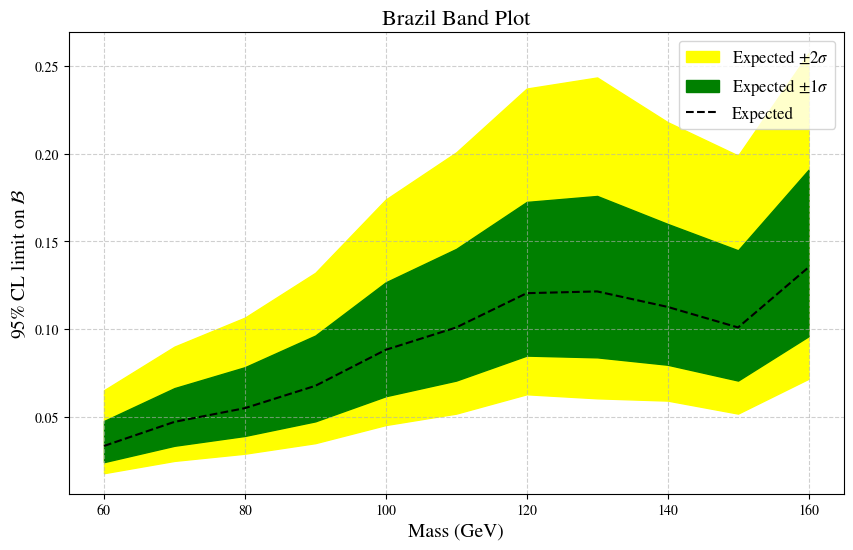

In [61]:
import re
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True

folder_path = "/home/pku/zhaoyz/pheno/notebooks_hbc/datacards"
mass_points = [mp for mp in range(60, 170, 10)]
observed_limits = []
expected_2_5 = []
expected_16 = []
expected_50 = []
expected_84 = []
expected_97_5 = []

for sig_idx, sig_sam in enumerate(list(config.sig_list.keys())):
    folder_path_i = f"{folder_path}/{sig_sam}"
    filename = "ObservedAsymptoticLimits.txt"
    file_path = os.path.join(folder_path_i, filename)
    with open(file_path, "r") as file:
        content = file.read()
        pattern = r"r < (\d+\.\d+)"
        limits = re.findall(pattern, content)
        limits = [float(limit) for limit in limits]
        observed_limits.append(limits[0])
        expected_2_5.append(limits[1])
        expected_16.append(limits[2])
        expected_50.append(limits[3])
        expected_84.append(limits[4])
        expected_97_5.append(limits[5])

plt.figure(figsize=(10, 6))

# 填充 Brazil Band 区域
plt.fill_between(mass_points, expected_2_5, expected_97_5, color='yellow', label=r'Expected $\pm2 \sigma$')
plt.fill_between(mass_points, expected_16, expected_84, color='green', label=r'Expected $\pm1 \sigma$')

# 绘制 Expected 50% 线
plt.plot(mass_points, expected_50, color='black', linestyle='--', label='Expected')

# 绘制 Observed Limit 线
# plt.plot(mass_points, observed_limits, color='red', marker='o', label='Observed Limit')

# 添加标签和标题
plt.xlabel('Mass (GeV)', fontsize=14)
plt.ylabel('95% CL limit on ' + r'$\mathcal{B}$', fontsize=14)
plt.title('Brazil Band Plot', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# 显示图像

plt.savefig(f"./exclude_v1.pdf", bbox_inches='tight')
plt.show()

### Other check

In [29]:
def read_root(filename = "./FitShapesB.root",  process = "sig"):
    with uproot.open(filename) as file:
        hist = file.get(process)
        h = np.array(hist.values())
        var = np.array(hist.variances())        
    return h, var


In [30]:
def check_root(filename = ""):
    value_sig, _ = read_root(filename=filename,process="sig")
    value_bkg1, _ = read_root(filename=filename,process="bkg_wjets")
    value_bkg2, _ = read_root(filename=filename,process="bkg_allwhad_tbc")
    value_bkg3, _ = read_root(filename=filename,process="bkg_allwhad_others")
    value_obs, _ = read_root(filename=filename,process="data_obs")
    
    print("signal",value_sig)
    # print("obs",value_obs)
    value_sum = value_bkg1 + value_bkg2 + value_bkg3
    print("all mc stacked",value_sum)
    return value_obs == value_sum

In [55]:
check_root("/home/pku/zhaoyz/pheno/notebooks_hbc/datacards/sig_m130/input_pt300to400_pass.root")

signal [0.75000579 0.         0.         0.75000579 1.50001159 4.50003477
 5.25004056 4.50003477 5.25004056 4.50003477 3.00002318 5.25004056
 1.50001159 2.25001738 4.50003477 0.75000579 0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
all mc stacked [0.00034072 0.00034072 0.00024271 0.00102414 0.00085179 0.00221466
 0.00467402 0.00245737 0.00102215 0.00262971 0.00221665 0.00340717
 0.00187395 0.00170359 0.00075378 0.00034072 0.00017036 0.00017036
 0.         0.         0.         0.         0.         0.
 0.        ]


array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True])